# Speaker recognition 

Import Libraries

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import sklearn.model_selection as sk
import glob
import os
import sounddevice as sd
import librosa
import librosa.display
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

from keras.regularizers import l2

Parameters

In [25]:
fs = 44100
no_mfcc=20
max_len=300

Custom dataset

Load files. Extract features

In [26]:
x=[]

y1=[]

for file in glob.glob("C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Datasets\\Custom\\All\\*"):
    basename=os.path.basename(file)
    person=basename.split("_")[1]
    y1.append(int(person))
    file_temp,fs_temp=librosa.load(file, sr=fs)
    mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
    if (max_len > mfcc_features.shape[1]):
        pad_width = max_len - mfcc_features.shape[1]
        mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc_features = mfcc_features[:, :max_len]
    x.append(mfcc_features)

RAVDESS Dataset

Load files. Extract features

In [185]:
x=[]
y =[]

y1=[]

for file in glob.glob("C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Datasets\\Ravdess\\All\\*"):
    basename=os.path.basename(file)
    emotion=basename.split("-")[2]
    person=basename.split("-")[6]
    person=person.split(".")[0]
    phrase=basename.split("-")[4]
    repetition=basename.split("-")[5]
    if(int(person)==1):
        y1.append(0)
        file_temp,fs_temp=librosa.load(file, sr=fs)
        #mfcc_features=librosa.feature.melspectrogram(file_temp,sr=fs,  n_mels=128, fmax=8000)
        mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
        if (max_len > mfcc_features.shape[1]):
            pad_width = max_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_features = mfcc_features[:, :max_len]
        x.append(mfcc_features)
        
    if(int(person)==3):
        y1.append(1)
        file_temp,fs_temp=librosa.load(file, sr=fs)
        #mfcc_features=librosa.feature.melspectrogram(file_temp,sr=fs,  n_mels=128, fmax=8000)
        mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
        if (max_len > mfcc_features.shape[1]):
            pad_width = max_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_features = mfcc_features[:, :max_len]
        x.append(mfcc_features)        


In [27]:
x=np.array(x)
y1=np.array(y1)
x.shape

(228, 20, 300)

In [35]:
#Note that mfcc operation returns (n_mfcc, time). 
#You have to do an axis permutation to get it to (time, n_mfcc) format. 
#So that the convolution happens on the time dimension.

In [36]:
##Normalize!!

Model

Model parameters

In [28]:
no_classes=max(y1)+1
no_channels=1

x_reshape=(x.shape[0],20,x.shape[2],no_channels)
input_shape=(20,x.shape[2],no_channels)

Create model

In [29]:
x = x.reshape(x_reshape)

x_train, x_test, y1_train, y1_test = sk.train_test_split(x,y1,test_size=0.3)
y1_train = tf.keras.utils.to_categorical(y1_train,num_classes=no_classes)
y1_test = tf.keras.utils.to_categorical(y1_test,num_classes=no_classes)

In [30]:
x_train.shape

(159, 20, 300, 1)

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(2, 2), kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))



model.add(layers.Conv2D(48, kernel_size=(2, 2),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))




model.add(layers.Flatten())

model.add(layers.Dense(no_classes, activation='softmax'))


In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 299, 32)       160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 149, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 149, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 148, 48)        6192      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 74, 48)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 74, 48)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14208)            

Compile model

In [33]:

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


Train model

In [34]:
history = model.fit(x_train, y1_train, epochs=45,verbose=1, validation_data=(x_test,y1_test))

Epoch 1/45
5/5 [==============================] - 1s 142ms/step - loss: 58.3081 - accuracy: 0.2516 - val_loss: 14.6282 - val_accuracy: 0.3478
Epoch 2/45
5/5 [==============================] - 1s 117ms/step - loss: 59.4098 - accuracy: 0.3082 - val_loss: 13.6832 - val_accuracy: 0.4638
Epoch 3/45
5/5 [==============================] - 0s 91ms/step - loss: 36.4325 - accuracy: 0.3774 - val_loss: 6.3690 - val_accuracy: 0.4058
Epoch 4/45
5/5 [==============================] - 1s 105ms/step - loss: 23.5508 - accuracy: 0.3648 - val_loss: 3.8807 - val_accuracy: 0.5652
Epoch 5/45
5/5 [==============================] - 0s 96ms/step - loss: 20.5930 - accuracy: 0.5660 - val_loss: 3.3087 - val_accuracy: 0.5217
Epoch 6/45
5/5 [==============================] - 0s 94ms/step - loss: 19.7154 - accuracy: 0.4591 - val_loss: 6.1050 - val_accuracy: 0.2609
Epoch 7/45
5/5 [==============================] - 1s 101ms/step - loss: 18.1112 - accuracy: 0.4843 - val_loss: 1.9136 - val_accuracy: 0.5507
Epoch 8/45
5/5

## Evaluate model

In [35]:
test_loss, test_acc = model.evaluate(x_test,  y1_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 1.2104 - accuracy: 0.8116

Test accuracy: 0.8115941882133484


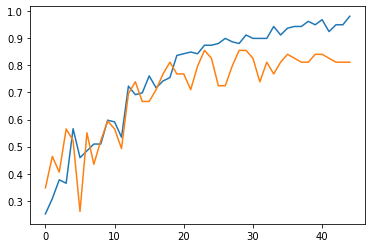

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

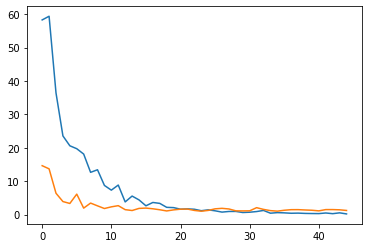

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


file="C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Code\\voice_01_1_neutral.wav"

file_temp,fs_temp=librosa.load(file, sr=fs)
mfcc_test=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=no_mfcc)
if (max_len > mfcc_test.shape[1]):
    pad_width = max_len - mfcc_test.shape[1]
    mfcc_test = np.pad(mfcc_test, pad_width=((0, 0), (0, pad_width)), mode='constant')
else:
    mfcc_test = mfcc_test[:, :max_len]

mfcc_test=mfcc_test.reshape((1,20,x.shape[2],no_channels))

In [38]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

ypred=[]
for i in range(0,len(predictions)):
    ypred.append(np.argmax(predictions[i]))
y_pred=np.array(ypred)    
print(ypred)
y_true=np.argmax(y1_test, axis=1)
print(y_true)

[0, 4, 4, 1, 2, 0, 2, 4, 3, 0, 0, 1, 4, 1, 2, 0, 2, 1, 4, 4, 0, 1, 1, 4, 0, 1, 0, 3, 4, 0, 0, 4, 4, 0, 4, 2, 4, 3, 4, 4, 0, 1, 2, 2, 0, 1, 0, 4, 2, 4, 2, 2, 0, 2, 4, 0, 0, 4, 4, 4, 2, 2, 4, 3, 0, 2, 0, 2, 0]
[0 4 4 1 2 0 2 4 3 2 1 4 4 1 2 3 2 1 4 2 0 1 1 2 0 1 0 3 4 0 0 4 4 0 1 2 4
 3 4 4 0 1 2 2 3 1 3 4 2 2 2 2 0 2 2 0 0 4 1 4 2 2 2 3 0 2 0 2 0]


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

In [40]:
f1_score(y_true, y_pred, average='micro')

0.8115942028985508

In [41]:
f1_score(y_true, y_pred, average='macro')

0.7991053391053391

In [42]:
precision_score(y_true, y_pred, average='micro')

0.8115942028985508

In [43]:
precision_score(y_true, y_pred, average='macro')

0.861111111111111

In [44]:
recall_score(y_true, y_pred, average='micro')

0.8115942028985508

In [45]:
recall_score(y_true, y_pred, average='macro')

0.7892640692640693

In [49]:
model.save('person_model')

INFO:tensorflow:Assets written to: person_model\assets


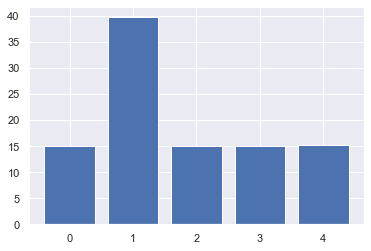

In [238]:
i = 0
thisplot = plt.bar(range(5), 100*predictions[0])


plt.show()

In [27]:
import pickle

In [30]:
with open ('person_model.pickle','wb') as f:
    pickle.dump(model,f)

TypeError: can't pickle _thread.RLock objects

In [16]:
predictions[0]

NameError: name 'predictions' is not defined

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

In [48]:
y_pred = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(y1_test, axis=1)
rounded_labels[1]

cnf_matrix = confusion_matrix(rounded_labels, y_pred)
cnf_matrix

array([[15,  0,  0,  0,  0],
       [ 1,  8,  0,  0,  2],
       [ 1,  0, 15,  0,  5],
       [ 3,  0,  0,  4,  0],
       [ 0,  1,  0,  0, 14]], dtype=int64)

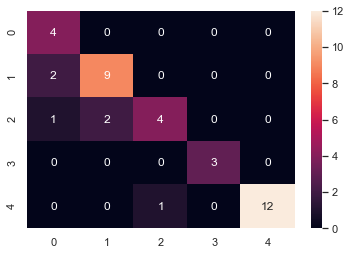

In [221]:
sns.heatmap(cnf_matrix,annot=True)